<a href="https://colab.research.google.com/github/ap0phasi/cerberusPy/blob/dev_s4layer/tests/example_cerberus_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modular CerberusTS Experimentation

First we make sure we are in the base working directory (this is probably not necessary if using the package):

Google Colab notebooks come with most of the packages we need, but we need to upgrade pandas and install accelerate.

Then we import the necessary CerberusTS modules.

In [1]:
!git clone --branch dev_s4layer https://github.com/ap0phasi/cerberusPy.git

Cloning into 'cerberusPy'...
remote: Enumerating objects: 466, done.
remote: Counting objects: 100% (55/55), done.
remote: Compressing objects: 100% (40/40), done.
remote: Total 466 (delta 31), reused 31 (delta 15), pack-reused 411
Receiving objects: 100% (466/466), 21.72 MiB | 21.39 MiB/s, done.
Resolving deltas: 100% (236/236), done.


In [2]:
import os
os.chdir('cerberusPy')

In [3]:
!pip install pandas==2.0.3
!pip install accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 45.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 346.6/346.6 kB 28.9 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 1.5.3
    Uninstalling pandas-1.5.3:
      Successfully uninstalled pandas-1.5.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.
google-colab 1.0.0 requires pandas==1.5.3, but you have pandas 2.0.3 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 270.9/270.9 kB 5.0 MB/s eta 0:00:00


In [4]:
from cerberus_ts import CerberusConfig
CerberusConfig.set_masked_norm_zero = True
CerberusConfig.processor_type = 'flatten'
CerberusConfig.foresight_residual = False

In [5]:
from cerberus_ts import Cerberus, train_cerberus
from cerberus_ts import Foresight, train_foresight
from cerberus_ts import TimeseriesDataPreparer, ResponseGenerator

import pandas as pd

## Dataset Loading

Next we need a Pandas Dataframe of some wide-formatted mutlivariate timeseries data. Here we will use the Jena Climate Data found here: https://www.kaggle.com/datasets/mnassrib/jena-climate

In [6]:
df = pd.read_csv(r"data/jena_climate_2009_2016.csv",
                parse_dates=['Date Time'],
                index_col=['Date Time'])
df.index = pd.to_datetime(df.index, format='%d.%m.%Y %H:%M:%S')
# For these tests we will just use a small slice of the dataset
df = df.iloc[:5000,:]

## User Argument Specification
There are a number of different arguments that can be provided to Cerberus, shown below:

In [7]:
# What ratio of data needs to be available for the various call, response, and context windows to use that timestamp?
thresholds = {
    'call': 1,
    'response': 1,
    'context_0': 1,
    'context_1': 1,
    'context_2': 1
}

# How big should the call, context(s), and response windows be?
sizes = {
    'call': 24,
    'response': 8,
    'context_0': 24,
    'context_1': 12,
    'context_2': 6
}

# What timestep should each head use?
window_timesteps = {
    'call': '10T',
    'response': '10T',
    'context_0': '1H',
    'context_1': '2H',
    'context_2': '6H'
}

# Which columns should be used for each head?
feature_indexes = {
    'call': range(0,14),
    'response': [0, 1, 4],
    'context_0': range(0,14),
    'context_1': range(0,14),
    'context_2': range(0,14)
}

## Prepare Dataset

We will use CerberusTS's TimeseriesDataPreparer class to create Torch dataloaders for all our different heads, scaled, downsampled, and coil-normalized for easy Cerberus use.

In [8]:
# Initialize the preparer
preparer = TimeseriesDataPreparer(df, sizes, thresholds, feature_indexes, window_timesteps, train_len = 20_000, feature_range = (0, 1), batch_size = 64)

# Prepare the data
preparer.prepare_data()

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [9]:
next(iter(preparer.dataloaders[0]))[0].device

device(type='cuda', index=0)

## Foresight Training

First, we can optionally train Foresight to aid CerberusTS:

In [10]:
foresight = Foresight(sizes=sizes,
                 feature_indexes=feature_indexes,
                 d_neck=512,
                 head_layers=["conv","conv"],
                 body_layer_sizes = [512, 256],
                 dropout_rate = 0.0,
                 eventualities = 10,
                 expander_sizes = [256, 512],
                 out_channels = 128,
                 kernel_size = 3)

In [11]:
foresight = train_foresight(foresight, preparer.dataloaders, num_epochs = 100)

Epoch [1/100], Loss: 0.007885334362633946
Epoch [2/100], Loss: 0.00446147674791856
Epoch [3/100], Loss: 0.0028395614675042857
Epoch [4/100], Loss: 0.0017805915026845166
Epoch [5/100], Loss: 0.001011228294997487
Epoch [6/100], Loss: 0.0006163522485332193
Epoch [7/100], Loss: 0.00042620209422353277
Epoch [8/100], Loss: 0.0003380618726758284
Epoch [9/100], Loss: 0.0002828848421651993
Epoch [10/100], Loss: 0.0002744550288816531
Epoch [11/100], Loss: 0.0002645859167193528
Epoch [12/100], Loss: 0.0002379117028230327
Epoch [13/100], Loss: 0.0002109309681592047
Epoch [14/100], Loss: 0.00023108678865563857
Epoch [15/100], Loss: 0.0002599745076429892
Epoch [16/100], Loss: 0.0002119256686483717
Epoch [17/100], Loss: 0.0002457026842695436
Epoch [18/100], Loss: 0.00043083418310566334
Epoch [19/100], Loss: 0.0003541303813805619
Epoch [20/100], Loss: 0.00012288043702331683
Epoch [21/100], Loss: 9.326233481566786e-05
Epoch [22/100], Loss: 9.261384946432984e-05
Epoch [23/100], Loss: 9.114622586373045e-

## CerberusTS Training (No Foresight)

In [12]:
cerberus_noforesight = Cerberus(sizes=sizes,
                 feature_indexes=feature_indexes,
                 d_neck=1028  ,
                 head_layers=["conv","conv"],
                 body_layer_sizes = [1028, 512, 256, 128],
                 dropout_rate = 0.0,
                 out_channels = 128,
                 kernel_size = 3)


In [13]:
cerberus_noforesight = train_cerberus(cerberus_noforesight, preparer.dataloaders, num_epochs = 100)

Epoch [1/100], Loss: 0.001329494152873699
Epoch [2/100], Loss: 0.000970672341078496
Epoch [3/100], Loss: 0.000876678020472185
Epoch [4/100], Loss: 0.0008172680192633956
Epoch [5/100], Loss: 0.0007661968509044748
Epoch [6/100], Loss: 0.0007310630387901324
Epoch [7/100], Loss: 0.0007022708320654969
Epoch [8/100], Loss: 0.0006696979577987354
Epoch [9/100], Loss: 0.0006393612201520984
Epoch [10/100], Loss: 0.0006215340992573676
Epoch [11/100], Loss: 0.0005836079000764158
Epoch [12/100], Loss: 0.0005716926684053625
Epoch [13/100], Loss: 0.0005523162958171532
Epoch [14/100], Loss: 0.0005287159301481419
Epoch [15/100], Loss: 0.0005134862018957401
Epoch [16/100], Loss: 0.0004876646981525004
Epoch [17/100], Loss: 0.0004609896699378229
Epoch [18/100], Loss: 0.0004567028158066618
Epoch [19/100], Loss: 0.0004344487843461755
Epoch [20/100], Loss: 0.0004101661263907545
Epoch [21/100], Loss: 0.00040455596299328236
Epoch [22/100], Loss: 0.0003744323416320454
Epoch [23/100], Loss: 0.0003603899480003359

## CerberusTS Training (With Foresight)
With the Foresight model trained (and weights frozen), we can pass this into a Cerberus model and train the remaining weights to generate predictions.

In [14]:
cerberus_foresight = Cerberus(sizes=sizes,
                 feature_indexes=feature_indexes,
                 d_neck=1028,
                 head_layers=["conv","conv"],
                 body_layer_sizes = [1028, 512, 256, 128],
                 dropout_rate = 0.0,
                 foresight = foresight,
                 eventualities = 10,
                 out_channels = 128,
                 kernel_size = 3)

In [15]:
cerberus_foresight = train_cerberus(cerberus_foresight, preparer.dataloaders, num_epochs = 100)

Epoch [1/100], Loss: 0.001304239340258427
Epoch [2/100], Loss: 0.0007813716526971425
Epoch [3/100], Loss: 0.000591761902960551
Epoch [4/100], Loss: 0.0004627288604195848
Epoch [5/100], Loss: 0.00037769313318470417
Epoch [6/100], Loss: 0.00032566818915737974
Epoch [7/100], Loss: 0.0002880191831952169
Epoch [8/100], Loss: 0.00025100957360381463
Epoch [9/100], Loss: 0.00023817082953686935
Epoch [10/100], Loss: 0.00020970079824809458
Epoch [11/100], Loss: 0.00019972399779083654
Epoch [12/100], Loss: 0.0001819341219264887
Epoch [13/100], Loss: 0.0001653175290342454
Epoch [14/100], Loss: 0.00015400088943528156
Epoch [15/100], Loss: 0.00013835720532993798
Epoch [16/100], Loss: 0.00013311249189722503
Epoch [17/100], Loss: 0.000120325992677333
Epoch [18/100], Loss: 0.00011758390603365358
Epoch [19/100], Loss: 0.00011313619028940039
Epoch [20/100], Loss: 0.00010697567121863922
Epoch [21/100], Loss: 0.0001086420994974758
Epoch [22/100], Loss: 9.917918537459232e-05
Epoch [23/100], Loss: 9.83353317

## Results Review

CerberusTS has some built in functionality for generating responses as well as visualizing the results.

### Normalized Response Review

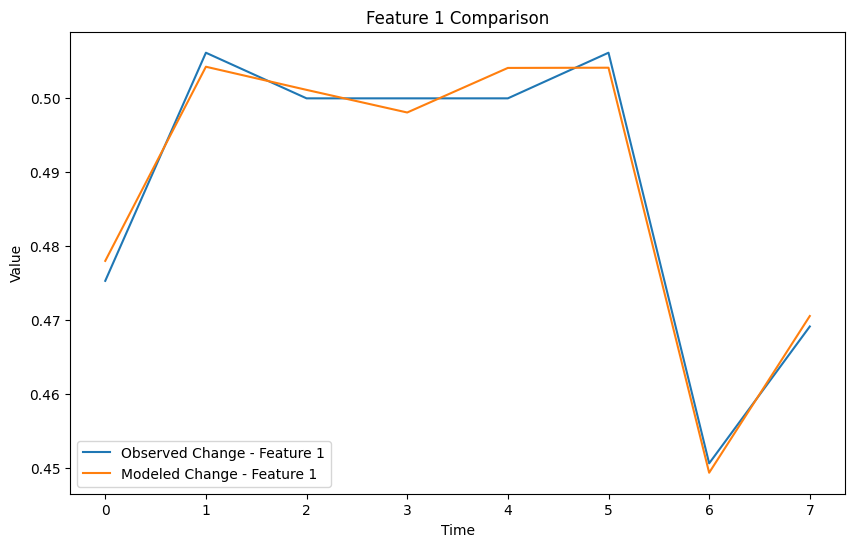

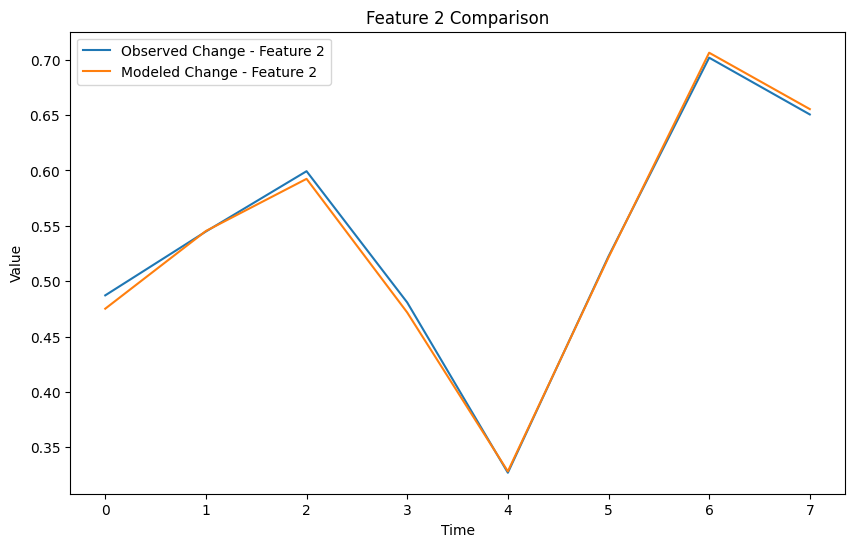

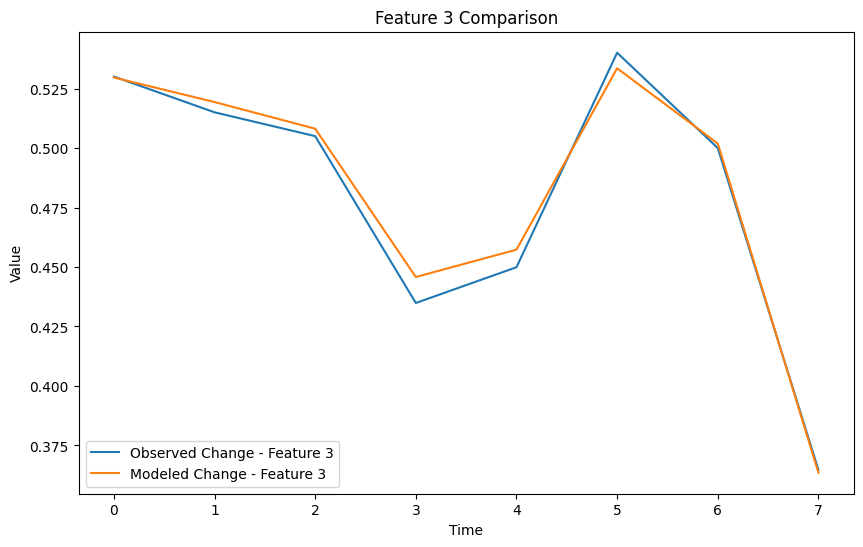

In [16]:
# Intialize Response Generator
generator = ResponseGenerator(cerberus_foresight, preparer.sliced_data, feature_indexes, preparer.max_change_dfs)

# Generate a response for a specific index
sel_index = 123
generator.generate_response(sel_index)

generator.plot_normalized_responses()

### Unscaled Response Review

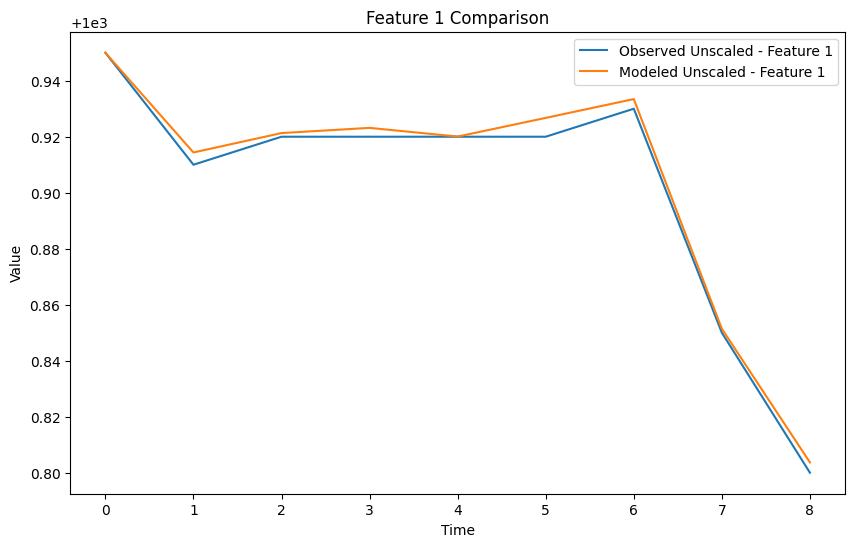

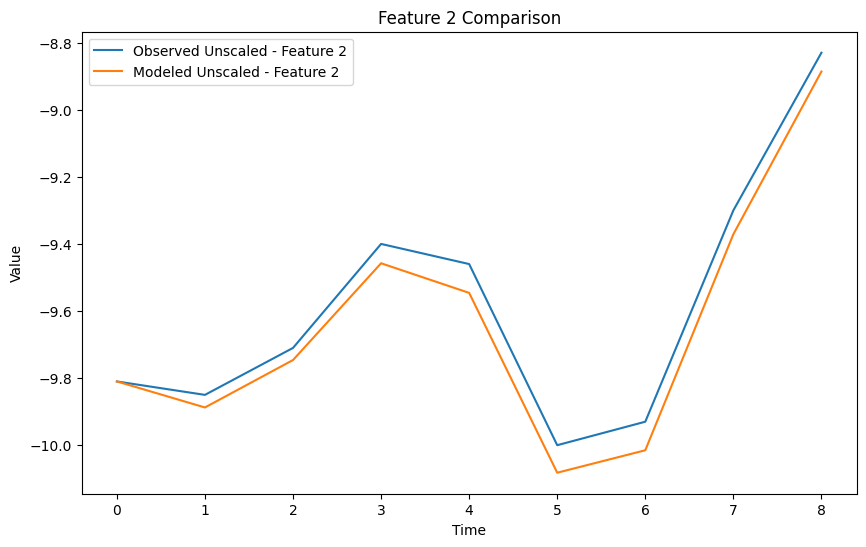

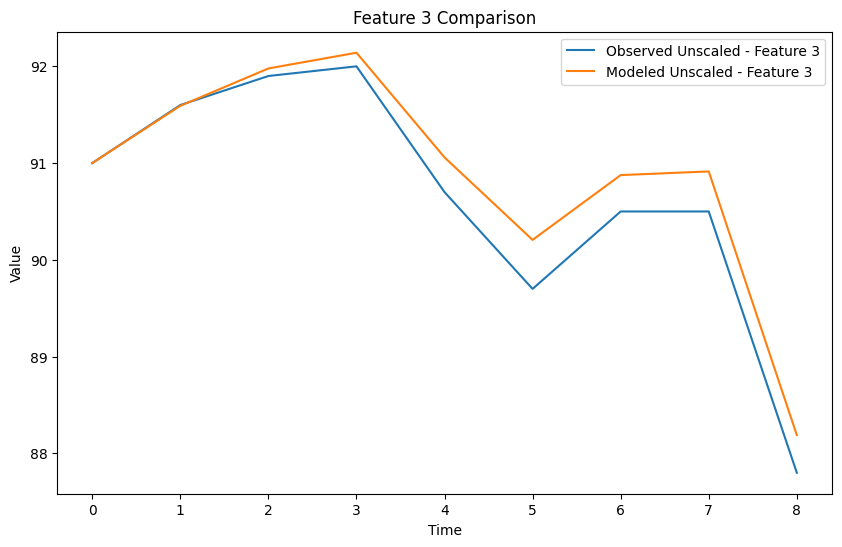

In [17]:
generator.plot_unscaled_responses(preparer.min_max_df, feature_indexes)